#### Summary:
Now that all cell type caQTLs with a larger window are done running with matrixQTL I'll colocalize them against all the various GWAS loci we have. I implemented the final method for this in a previous notebook (`240425_matrixQTL_caQTL_GWAS_Coloc.ipynb`), and here I'll run it on all cell types and all GWAS sumstats sets. I'm going to reorganize this a bit so that I can loop through all the GWAS in one go, rather than have to keep checking up on the notebook.

In [3]:
suppressMessages(library(vroom))
suppressMessages(library(data.table))
suppressMessages(library(coloc))
suppressMessages(library(stringr))
suppressMessages(library(dplyr))
suppressMessages(library(tictoc))
suppressMessages(library(ggplot2))
suppressMessages(library(ggpubr))
suppressMessages(library(UpSetR))

In [4]:
options(scipen=999)

In [5]:
theme_set(theme_classic())

In [6]:
# outdir <- '/nfs/lab/projects/multiomic_islet/outputs/genotypes/caQTL_GWAS_coloc'
outdir <- '/nfs/lab/projects/multiomic_islet/outputs/genotypes/240521_caQTL_GWAS_coloc_cts'

In [7]:
t1d_fp <- '/nfs/lab/cmcgrail/T1D_GWAS/EARLY_finn/T1D_meta_EARY_finns.all_chr.sumstats.txt'
t2d_fp <- '/nfs/lab/projects/multiomic_islet/references/hg38_GWAS/T2D_DIAMANTE/all_chrs_sumstats_hg38.txt.gz'
glu2h_fp <- '/nfs/lab/projects/multiomic_islet/references/hg38_GWAS/MAGIC1000G_2hGlu_EUR/all_chrs_sumstats_hg38.txt.gz'
fg_fp <- '/nfs/lab/projects/multiomic_islet/references/hg38_GWAS/MAGIC1000G_FG_EUR/all_chrs_sumstats_hg38.txt.gz'
fi_fp <- '/nfs/lab/projects/multiomic_islet/references/hg38_GWAS/MAGIC1000G_FI_EUR/all_chrs_sumstats_hg38.txt.gz'
hba1c_fp <- '/nfs/lab/projects/multiomic_islet/references/hg38_GWAS/MAGIC1000G_HbA1c_EUR/all_chrs_sumstats_hg38.txt.gz'

In [8]:
celltypes <- c('beta','alpha','delta','gamma','acinar','ductal','bulk')

In [9]:
major_colors = c('acinar'='#09850B', 'alpha'='#F51646', 'beta'='#3F98E0',
                 'delta'='#FFA946', 'ductal'='#F5DE6C', 'endothelial'='#752BBA', 
                 'gamma'='#A1D99B', 'immune'='#F598C9', 'stellate'='#AB7345',
                 'bulk'='#999999')

# Coloc functions

In [6]:
### Function to get allele freq for a subset of SNPs (listed in df)
get_af <- function(caqtl, feature){
    #read in chromosome vcf
    chrom <- str_split(feature,':')[[1]][1]
    af_fp <- sprintf('/nfs/lab/welison/islet_multiome/intermediates/caQTLs/231026_WE_caQTLs/caQTLs_rasqual/beta/vcfs_peaks100kb/%s.ase.nofilt.vcf.gz',chrom)
    vcf <- suppressMessages(vroom::vroom(af_fp, skip=29))
    
    #cut down vcf to useful columns
    vcf2 <- vcf %>% select(ID, REF, ALT, INFO)
    colnames(vcf2) <- c('ID','Ref','Alt','Info')

    #merge with caQTL results
    snps <- merge(caqtl, vcf2, by.x=c('rsID','Ref','Alt'), by.y=c('ID','Ref','Alt'))

    #pull out MAF to Af column
    vcf_info <- as.data.frame(str_split_fixed(snps$Info, ';', 3))
    af <- as.numeric(gsub('AF=','',vcf_info$V1))
    return(af)
}

In [7]:
### Function to read in caQTL output file for a feature of interest
### feature should be written: chr#:start-end
read_caQTL <- function(feature, celltype, caqtl_dir){
    #read in matrixQTL output for the feature
    caqtl_fp <- file.path(caqtl_dir, celltype, sprintf('%s_Matrix_QTL_Results_100kb.tsv',feature))
    caqtl <- suppressMessages(vroom::vroom(caqtl_fp, show_col_types = FALSE))
    
    #modify columns to match previous caQTL column names
    #current cols: SNP	gene	beta	t-stat	p-value	FDR
    #needed cols: rsID, Feature, Chromosome, position, Alt, Ref, Af, Effect_size, P_VAl
    colnames(caqtl) <- c('rsID','Feature','Effect_size','T_stat','P_VAl','FDR')
    
    #extract other necessary info
    caqtl$ster <- caqtl$Effect_size/caqtl$T_stat
    
    #get alleles and maf
    snp_info <- as.data.frame(str_split_fixed(caqtl$rsID, ':', 4))
    colnames(snp_info) <- c('Chromosome','position','Ref','Alt')
    snp_info <- snp_info %>% mutate_at('position', as.numeric)
    fin_caqtl <- cbind(caqtl,snp_info)
    fin_caqtl$Af <- get_af(fin_caqtl, feature)
    
    return(fin_caqtl)
}

In [8]:
### Function to run coloc loop for all caQTLs for an input celltype -- just T1D GWAS for now, 
### but hopefully can change that later (starting point is which # unique(Features) to start on)
run_gwas_coloc <- function(celltype, features, caqtl_dir, gwas, gwas_prefix, outdir, n_track){
    # Set up log file
    dir.create(file.path(outdir,'logs'),showWarnings=FALSE)
    log_fp <- file.path(outdir,'logs',sprintf('%s_caQTL_features_T1D_coloc_log.txt',celltype))
    write(sprintf('Starting %s caQTL and %s coloc: %s', celltype, gwas_prefix, Sys.time()),log_fp,append=TRUE)
    
    # Cut down features to just those overlapping lead variant loci for gwas of interest!
    lead_var_fp <- '/nfs/lab/projects/multiomic_islet/references/hg38_GWAS/lead_variants/final_peaks_mergedPeak.overlap_all_lead_variants_100kb_windows.wINFO.bed'
    lead_vars <- read.table(lead_var_fp, sep='\t')
    colnames(lead_vars) <- c('chr1','start1','end1','chr2','start2','end2','rsID','trait','gwas')
    lead_vars$feature <- paste(lead_vars$chr1,paste(lead_vars$start1,lead_vars$end1,sep='-'),sep=':')
    gwas_features <- subset(lead_vars, trait==gwas_prefix) %>% pull(feature)
    features_cut <- features[features %in% gwas_features]
    write(sprintf('%s features to coloc: %s', length(features_cut), Sys.time()),log_fp,append=TRUE)
    
    # Prep df for saving results and logging tracker
    result_table <- data.frame()
    tracker <- 0
    
    # Loop through each caQTL feature and coloc
    for (x in features_cut){
        # Write log message every n_track QTLs
        if (tracker %% n_track == 0){
            write(sprintf('Starting coloc for feature %s (%s): %s', tracker, x, Sys.time()),log_fp,append=TRUE)
        }
        tracker <- tracker + 1
        print(x)
        
        #get coloc data frame for feature
        #feature <- caqtl[which(caqtl$Feature == x),] #Subset cell type caQTL results to feature of interest
        feature <- read_caQTL(x, celltype, caqtl_dir)
        feature_name <- c(x)
        feature$chr_pos <- paste0(feature$Chromosome,':', feature$position)
        gwas_subset <- gwas[which(gwas$chr_pos %in% feature$chr_pos),]
        
        # CHECK IF ANY GWAS SNPS REMAIN AFTER SUBSETTING; IF NOT, SKIP COLOC
        if (dim(gwas_subset)[1] == 0){
            write(sprintf('No overlapping GWAS SNPs for feature: %s', x),log_fp,append=TRUE)
        } else {
            #These next 2 lines check that the alleles match in case the allele frequencies are in different format
            feature$alleles <- apply(feature[,c('Alt', 'Ref')], 1, function(x) paste(x[order(x)], collapse=''))
            gwas_subset$alleles <- apply(gwas_subset[,c('ALT', 'REF')], 1, function(x) paste(x[order(x)], collapse=''))

            #Coloc requires the 2 datasets to have all of the exact same SNPs, I do this by making a merged table
            m <- merge(gwas_subset,feature, by.x=c('CHR', 'POS', 'alleles'), by.y=c('Chromosome', 'position', 'alleles'))
            m <- m[!duplicated(m$SNPID)]

            # 4/28/24 New check: make sure there's any overlap before proceeding
            if(dim(m)[1] > 0){
                #Checks allele frequency format, required to be in MAF (minor allele frequency)
                ##If not in MAF, will flip alleles and frequency so it will be MAF
                m$gwas_maf <- sapply(m$AF, function(x) min(c(x, 1-x)))
                m$gwas_flip <- m$AF < 0.5
                m$gwas_beta_alt <- m$BETA * (c(-1,1)[m$gwas_flip +1]) 
                m$caqtl_maf <- sapply(m$Af, function(x) min(c(x, 1-x)))
                m$caqtl_flip <- m$Af < 0.5
                m$caqtl_beta_alt <- m$Effect_size*(c(-1,1)[m$caqtl_flip +1]) 

                #Coloc has trouble if MAF is 0 or 1, remove those instances
                m <-m[!(m$gwas_maf == 0)]
                m <-m[!(m$AF == 0)]
                m <-m[!(m$caqtl_maf == 1)]
                m <-m[!(m$Af == 1)]

                #Assigning dataset 1 and 2 to caQTL and GWAS. Assigning from the merged table ensures dimensions are always the same
                caqtl_dataset = list(beta = m$caqtl_beta_alt,
                                     varbeta=m$ster^2,
                                     pvalues = m$P_VAl,
                                     type = 'quant', 
                                     snp = m$rsID,
                                     MAF = m$caqtl_maf, 
                                     N = 27)

                gwas_dataset = list(beta = m$gwas_beta_alt,
                                    varbeta = m$SE^2,
                                    type = 'quant',
                                    snp = m$SNPID,
                                    MAF = m$gwas_maf, 
                                    N = m$N)

                #Run coloc with single shared causal variant assumption
                coloc_res <- suppressWarnings(coloc::coloc.abf(dataset1 = caqtl_dataset, dataset2 = gwas_dataset,
                                                               p1 = 1e-4, p2 = 1e-4, p12 = 1e-5))
                result0 <- as.list(coloc_res$summary)

                #Output probabilities
                ppH0 <-result0$PP.H0.abf
                ppH1 <-result0$PP.H1.abf
                ppH2 <-result0$PP.H2.abf
                ppH3 <-result0$PP.H3.abf
                ppH4 <-result0$PP.H4.abf  

                #Save results to a dataframe and rbind each time you loop through a feature
                results <- cbind(feature_name, ppH0, ppH1, ppH2, ppH3, ppH4)
                result_table <- rbind(result_table, results)
                out_fp <- file.path(outdir, sprintf('%s_caQTL_features_%s_coloc.txt',celltype,gwas_prefix))
                fwrite(result_table, out_fp, sep='\t', quote=F, row.names=F, col.names=T)                
            }
        }
    }
}

In [38]:
fin_wrapper <- function(celltype, gwas, gwas_prefix){
    gwas_outdir <- file.path(outdir,gwas_prefix)
    dir.create(gwas_outdir, showWarnings=FALSE)
    
    ct_features <- get_ct_features(celltype)
    run_gwas_coloc(celltype, ct_features, caqtl_dir, gwas, gwas_prefix, gwas_outdir, 500)
}

# Functions for reading in caQTLs by cell type
Example matrixQTL outputs from Weston:
- Tested features: `/nfs/lab/welison/islet_multiome/intermediates/caQTLs/231026_WE_caQTLs/gwas_overlap/Matrix_QTL_Inputs/Features.beta.tsv`
- Full table: `/nfs/lab/welison/islet_multiome/intermediates/caQTLs/231026_WE_caQTLs/gwas_overlap/Matrix_QTL_Inputs/Full_Matrix_QTL_Results_beta.tsv`
- Results per feature: `/nfs/lab/welison/islet_multiome/intermediates/caQTLs/231026_WE_caQTLs/gwas_overlap/Matrix_QTL_Inputs/beta/chr9:94782343-94783599_Matrix_QTL_Results_100kb.tsv`

Previously coloc files for ref: `/nfs/lab/welison/islet_multiome/intermediates/caQTLs/231026_WE_caQTLs/caQTLs_rasqual/${celltype}/run1/Results_run1F_all.tsv`

In [9]:
caqtl_dir <- '/nfs/lab/welison/islet_multiome/intermediates/caQTLs/231026_WE_caQTLs/gwas_overlap/Matrix_QTL_Inputs'

In [18]:
get_ct_features <- function(celltype){
    #get list of features for caQTLs (will loop through for coloc)
    features_fp <- file.path(caqtl_dir,sprintf('Features.%s.tsv',celltype))
    features <- scan(features_fp, what='', sep='\n')
    return(features)
}

# Perform coloc on all disease sumstats

## T1D

In [11]:
#### SELECT WHICH GWAS TO PERFORM COLOC WITH HERE!
gwas_prefix <- 'T1D' #needs to match phenotype abbrev in file I ref to cut down features
gwas_fp <- t1d_fp

In [12]:
tic()
gwas <- fread(gwas_fp, header=TRUE)
toc()
dim(gwas)
head(gwas)

171.151 sec elapsed


[1] 62129693       14

SNPID,CHR,POS,REF,ALT,BETA,SE,PVALUE,N,N_CASE,N_CTRL,AF,AF_CASE,AF_CTRL
<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1:10177:A:AC,1,10177,A,AC,0.059058,0.055112,2.839e-01,363495,1445,362050,0.397669,0.404238,0.397643
1:10352:T:TA,1,10352,T,TA,0.019496,0.056730,7.311e-01,363495,1445,362050,0.392616,0.394730,0.392608
1:10511:G:A,1,10511,G,A,-0.148768,0.756536,8.441e-01,363495,1445,362050,0.001310,0.001223,0.001310
1:10616:CCGCCGTTGCAAAGGCGCGCCG:C,1,10616,CCGCCGTTGCAAAGGCGCGCCG,C,0.242325,0.362319,5.036e-01,363495,1445,362050,0.994247,0.994884,0.994244
1:10642:G:A,1,10642,G,A,-1.330179,1.968856,4.993e-01,363495,1445,362050,0.000214,0.000099,0.000215
1:11008:C:G,1,11008,C,G,-0.077214,0.094349,4.131e-01,363495,1445,362050,0.086074,0.083190,0.086085


In [13]:
# T1D modifications
gwas <- gwas[gwas$CHR != 'X',]
gwas$CHR <- paste0('chr', gwas$CHR)
gwas$SNPID <- paste0('chr', gwas$SNPID)
gwas$PVALUE <- as.numeric(gwas$PVALUE)
gwas$chr_pos <- paste0(gwas$CHR,':',gwas$POS)

# T2D modifications
# gwas <- subset(gwas, CHR != 'X') %>%
#         mutate(CHR2=paste0('chr',CHR)) %>% select(-CHR, -chr) %>% 
#         rename(CHR=CHR2) %>% relocate(CHR) %>%
#         select(-POS) %>% rename(POS=pos_hg38) %>%
#         rename(REF=A2, ALT=A1, AF=FREQ1) %>%
#         mutate(SNPID=paste(CHR,POS,REF,ALT,sep=':')) %>%
#         select(-rsID,-SNP) %>%
#         mutate(chr_pos=paste0(CHR,':',POS)) %>%
#         mutate_at(c('PVALUE','AF'),as.numeric)

# Glycemic trait modifications
# gwas <- subset(gwas, chr != 'X') %>%
#         mutate(CHR=paste0('chr',chr)) %>% select(-chr,-chromosome) %>% 
#         relocate(CHR) %>%
#         rename(POS=pos_hg38) %>% select(-base_pair_location, -rsID) %>%
#         rename(REF=other_allele, ALT=effect_allele, AF=effect_allele_frequency) %>%
#         mutate(SNPID=paste(CHR,POS,REF,ALT,sep=':')) %>%
#         rename(BETA=beta, SE=standard_error, PVALUE=p_value, N=sample_size) %>%
#         mutate(chr_pos=paste0(CHR,':',POS)) %>%
#         mutate_at(c('PVALUE','AF'),as.numeric)

head(gwas)

SNPID,CHR,POS,REF,ALT,BETA,SE,PVALUE,N,N_CASE,N_CTRL,AF,AF_CASE,AF_CTRL,chr_pos
<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
chr1:10177:A:AC,chr1,10177,A,AC,0.059058,0.055112,0.2839,363495,1445,362050,0.397669,0.404238,0.397643,chr1:10177
chr1:10352:T:TA,chr1,10352,T,TA,0.019496,0.056730,0.7311,363495,1445,362050,0.392616,0.394730,0.392608,chr1:10352
chr1:10511:G:A,chr1,10511,G,A,-0.148768,0.756536,0.8441,363495,1445,362050,0.001310,0.001223,0.001310,chr1:10511
chr1:10616:CCGCCGTTGCAAAGGCGCGCCG:C,chr1,10616,CCGCCGTTGCAAAGGCGCGCCG,C,0.242325,0.362319,0.5036,363495,1445,362050,0.994247,0.994884,0.994244,chr1:10616
chr1:10642:G:A,chr1,10642,G,A,-1.330179,1.968856,0.4993,363495,1445,362050,0.000214,0.000099,0.000215,chr1:10642
chr1:11008:C:G,chr1,11008,C,G,-0.077214,0.094349,0.4131,363495,1445,362050,0.086074,0.083190,0.086085,chr1:11008


In [14]:
#subset to just variants with AF values??? -- cuts out A TON but idk what else to do here?
table(is.na(gwas$AF))
gwas <- subset(gwas, !is.na(AF))
table(is.na(gwas$AF))


   FALSE 
59821925 


   FALSE 
59821925 

In [ ]:
parallel::mclapply(celltypes, fin_wrapper, gwas, gwas_prefix, mc.cores=7)

## T2D

In [ ]:
#### SELECT WHICH GWAS TO PERFORM COLOC WITH HERE!
gwas_prefix <- 'T2D' #needs to match phenotype abbrev in file I ref to cut down features
gwas_fp <- t2d_fp

In [ ]:
tic()
gwas <- fread(gwas_fp, header=TRUE)
toc()
dim(gwas)
head(gwas)

In [ ]:
# T1D modifications
# gwas <- gwas[gwas$CHR != 'X',]
# gwas$CHR <- paste0('chr', gwas$CHR)
# gwas$SNPID <- paste0('chr', gwas$SNPID)
# gwas$PVALUE <- as.numeric(gwas$PVALUE)
# gwas$chr_pos <- paste0(gwas$CHR,':',gwas$POS)

# T2D modifications
gwas <- subset(gwas, CHR != 'X') %>%
        mutate(CHR2=paste0('chr',CHR)) %>% select(-CHR, -chr) %>% 
        rename(CHR=CHR2) %>% relocate(CHR) %>%
        select(-POS) %>% rename(POS=pos_hg38) %>%
        rename(REF=A2, ALT=A1, AF=FREQ1) %>%
        mutate(SNPID=paste(CHR,POS,REF,ALT,sep=':')) %>%
        select(-rsID,-SNP) %>%
        mutate(chr_pos=paste0(CHR,':',POS)) %>%
        mutate_at(c('PVALUE','AF'),as.numeric)

# Glycemic trait modifications
# gwas <- subset(gwas, chr != 'X') %>%
#         mutate(CHR=paste0('chr',chr)) %>% select(-chr,-chromosome) %>% 
#         relocate(CHR) %>%
#         rename(POS=pos_hg38) %>% select(-base_pair_location, -rsID) %>%
#         rename(REF=other_allele, ALT=effect_allele, AF=effect_allele_frequency) %>%
#         mutate(SNPID=paste(CHR,POS,REF,ALT,sep=':')) %>%
#         rename(BETA=beta, SE=standard_error, PVALUE=p_value, N=sample_size) %>%
#         mutate(chr_pos=paste0(CHR,':',POS)) %>%
#         mutate_at(c('PVALUE','AF'),as.numeric)

head(gwas)

In [ ]:
#subset to just variants with AF values??? -- cuts out A TON but idk what else to do here?
table(is.na(gwas$AF))
gwas <- subset(gwas, !is.na(AF))
table(is.na(gwas$AF))

In [ ]:
parallel::mclapply(celltypes, fin_wrapper, gwas, gwas_prefix, mc.cores=7)

## 2hGlu

In [ ]:
#### SELECT WHICH GWAS TO PERFORM COLOC WITH HERE!
gwas_prefix <- '2hGlu' #needs to match phenotype abbrev in file I ref to cut down features
gwas_fp <- glu2h_fp

In [ ]:
tic()
gwas <- fread(gwas_fp, header=TRUE)
toc()
dim(gwas)
head(gwas)

In [ ]:
# T1D modifications
# gwas <- gwas[gwas$CHR != 'X',]
# gwas$CHR <- paste0('chr', gwas$CHR)
# gwas$SNPID <- paste0('chr', gwas$SNPID)
# gwas$PVALUE <- as.numeric(gwas$PVALUE)
# gwas$chr_pos <- paste0(gwas$CHR,':',gwas$POS)

# T2D modifications
# gwas <- subset(gwas, CHR != 'X') %>%
#         mutate(CHR2=paste0('chr',CHR)) %>% select(-CHR, -chr) %>% 
#         rename(CHR=CHR2) %>% relocate(CHR) %>%
#         select(-POS) %>% rename(POS=pos_hg38) %>%
#         rename(REF=A2, ALT=A1, AF=FREQ1) %>%
#         mutate(SNPID=paste(CHR,POS,REF,ALT,sep=':')) %>%
#         select(-rsID,-SNP) %>%
#         mutate(chr_pos=paste0(CHR,':',POS)) %>%
#         mutate_at(c('PVALUE','AF'),as.numeric)

# Glycemic trait modifications
gwas <- subset(gwas, chr != 'X') %>%
        mutate(CHR=paste0('chr',chr)) %>% select(-chr,-chromosome) %>% 
        relocate(CHR) %>%
        rename(POS=pos_hg38) %>% select(-base_pair_location, -rsID) %>%
        rename(REF=other_allele, ALT=effect_allele, AF=effect_allele_frequency) %>%
        mutate(SNPID=paste(CHR,POS,REF,ALT,sep=':')) %>%
        rename(BETA=beta, SE=standard_error, PVALUE=p_value, N=sample_size) %>%
        mutate(chr_pos=paste0(CHR,':',POS)) %>%
        mutate_at(c('PVALUE','AF'),as.numeric)

head(gwas)

In [ ]:
#subset to just variants with AF values??? -- cuts out A TON but idk what else to do here?
table(is.na(gwas$AF))
gwas <- subset(gwas, !is.na(AF))
table(is.na(gwas$AF))

In [ ]:
parallel::mclapply(celltypes, fin_wrapper, gwas, gwas_prefix, mc.cores=7)

## FG

In [ ]:
#### SELECT WHICH GWAS TO PERFORM COLOC WITH HERE!
gwas_prefix <- 'FG' #needs to match phenotype abbrev in file I ref to cut down features
gwas_fp <- fg_fp

In [ ]:
tic()
gwas <- fread(gwas_fp, header=TRUE)
toc()
dim(gwas)
head(gwas)

In [ ]:
# T1D modifications
# gwas <- gwas[gwas$CHR != 'X',]
# gwas$CHR <- paste0('chr', gwas$CHR)
# gwas$SNPID <- paste0('chr', gwas$SNPID)
# gwas$PVALUE <- as.numeric(gwas$PVALUE)
# gwas$chr_pos <- paste0(gwas$CHR,':',gwas$POS)

# T2D modifications
# gwas <- subset(gwas, CHR != 'X') %>%
#         mutate(CHR2=paste0('chr',CHR)) %>% select(-CHR, -chr) %>% 
#         rename(CHR=CHR2) %>% relocate(CHR) %>%
#         select(-POS) %>% rename(POS=pos_hg38) %>%
#         rename(REF=A2, ALT=A1, AF=FREQ1) %>%
#         mutate(SNPID=paste(CHR,POS,REF,ALT,sep=':')) %>%
#         select(-rsID,-SNP) %>%
#         mutate(chr_pos=paste0(CHR,':',POS)) %>%
#         mutate_at(c('PVALUE','AF'),as.numeric)

# Glycemic trait modifications
gwas <- subset(gwas, chr != 'X') %>%
        mutate(CHR=paste0('chr',chr)) %>% select(-chr,-chromosome) %>% 
        relocate(CHR) %>%
        rename(POS=pos_hg38) %>% select(-base_pair_location, -rsID) %>%
        rename(REF=other_allele, ALT=effect_allele, AF=effect_allele_frequency) %>%
        mutate(SNPID=paste(CHR,POS,REF,ALT,sep=':')) %>%
        rename(BETA=beta, SE=standard_error, PVALUE=p_value, N=sample_size) %>%
        mutate(chr_pos=paste0(CHR,':',POS)) %>%
        mutate_at(c('PVALUE','AF'),as.numeric)

head(gwas)

In [ ]:
#subset to just variants with AF values??? -- cuts out A TON but idk what else to do here?
table(is.na(gwas$AF))
gwas <- subset(gwas, !is.na(AF))
table(is.na(gwas$AF))

In [ ]:
parallel::mclapply(celltypes, fin_wrapper, gwas, gwas_prefix, mc.cores=7)

# FI

In [ ]:
#### SELECT WHICH GWAS TO PERFORM COLOC WITH HERE!
gwas_prefix <- 'FI' #needs to match phenotype abbrev in file I ref to cut down features
gwas_fp <- fi_fp

In [ ]:
tic()
gwas <- fread(gwas_fp, header=TRUE)
toc()
dim(gwas)
head(gwas)

In [ ]:
# T1D modifications
# gwas <- gwas[gwas$CHR != 'X',]
# gwas$CHR <- paste0('chr', gwas$CHR)
# gwas$SNPID <- paste0('chr', gwas$SNPID)
# gwas$PVALUE <- as.numeric(gwas$PVALUE)
# gwas$chr_pos <- paste0(gwas$CHR,':',gwas$POS)

# T2D modifications
# gwas <- subset(gwas, CHR != 'X') %>%
#         mutate(CHR2=paste0('chr',CHR)) %>% select(-CHR, -chr) %>% 
#         rename(CHR=CHR2) %>% relocate(CHR) %>%
#         select(-POS) %>% rename(POS=pos_hg38) %>%
#         rename(REF=A2, ALT=A1, AF=FREQ1) %>%
#         mutate(SNPID=paste(CHR,POS,REF,ALT,sep=':')) %>%
#         select(-rsID,-SNP) %>%
#         mutate(chr_pos=paste0(CHR,':',POS)) %>%
#         mutate_at(c('PVALUE','AF'),as.numeric)

# Glycemic trait modifications
gwas <- subset(gwas, chr != 'X') %>%
        mutate(CHR=paste0('chr',chr)) %>% select(-chr,-chromosome) %>% 
        relocate(CHR) %>%
        rename(POS=pos_hg38) %>% select(-base_pair_location, -rsID) %>%
        rename(REF=other_allele, ALT=effect_allele, AF=effect_allele_frequency) %>%
        mutate(SNPID=paste(CHR,POS,REF,ALT,sep=':')) %>%
        rename(BETA=beta, SE=standard_error, PVALUE=p_value, N=sample_size) %>%
        mutate(chr_pos=paste0(CHR,':',POS)) %>%
        mutate_at(c('PVALUE','AF'),as.numeric)

head(gwas)

In [ ]:
#subset to just variants with AF values??? -- cuts out A TON but idk what else to do here?
table(is.na(gwas$AF))
gwas <- subset(gwas, !is.na(AF))
table(is.na(gwas$AF))

In [ ]:
parallel::mclapply(celltypes, fin_wrapper, gwas, gwas_prefix, mc.cores=7)

# HbA1c

In [ ]:
#### SELECT WHICH GWAS TO PERFORM COLOC WITH HERE!
gwas_prefix <- 'HbA1c' #needs to match phenotype abbrev in file I ref to cut down features
gwas_fp <- hba1c_fp

In [ ]:
tic()
gwas <- fread(gwas_fp, header=TRUE)
toc()
dim(gwas)
head(gwas)

In [ ]:
# T1D modifications
# gwas <- gwas[gwas$CHR != 'X',]
# gwas$CHR <- paste0('chr', gwas$CHR)
# gwas$SNPID <- paste0('chr', gwas$SNPID)
# gwas$PVALUE <- as.numeric(gwas$PVALUE)
# gwas$chr_pos <- paste0(gwas$CHR,':',gwas$POS)

# T2D modifications
# gwas <- subset(gwas, CHR != 'X') %>%
#         mutate(CHR2=paste0('chr',CHR)) %>% select(-CHR, -chr) %>% 
#         rename(CHR=CHR2) %>% relocate(CHR) %>%
#         select(-POS) %>% rename(POS=pos_hg38) %>%
#         rename(REF=A2, ALT=A1, AF=FREQ1) %>%
#         mutate(SNPID=paste(CHR,POS,REF,ALT,sep=':')) %>%
#         select(-rsID,-SNP) %>%
#         mutate(chr_pos=paste0(CHR,':',POS)) %>%
#         mutate_at(c('PVALUE','AF'),as.numeric)

# Glycemic trait modifications
gwas <- subset(gwas, chr != 'X') %>%
        mutate(CHR=paste0('chr',chr)) %>% select(-chr,-chromosome) %>% 
        relocate(CHR) %>%
        rename(POS=pos_hg38) %>% select(-base_pair_location, -rsID) %>%
        rename(REF=other_allele, ALT=effect_allele, AF=effect_allele_frequency) %>%
        mutate(SNPID=paste(CHR,POS,REF,ALT,sep=':')) %>%
        rename(BETA=beta, SE=standard_error, PVALUE=p_value, N=sample_size) %>%
        mutate(chr_pos=paste0(CHR,':',POS)) %>%
        mutate_at(c('PVALUE','AF'),as.numeric)

head(gwas)

In [ ]:
#subset to just variants with AF values??? -- cuts out A TON but idk what else to do here?
table(is.na(gwas$AF))
gwas <- subset(gwas, !is.na(AF))
table(is.na(gwas$AF))

In [ ]:
parallel::mclapply(celltypes, fin_wrapper, gwas, gwas_prefix, mc.cores=7)

# Pull out significant results and summarize

In [6]:
gwas_prefixes <- c('T1D','T2D','2hGlu','FG','FI','HbA1c')

In [7]:
scenario_map <- c('ppH0'='Neither','ppH1'='Only caQTL','ppH2'='Only GWAS',
                  'ppH3'='Diff causal variants','ppH4'='Shared causal variant')
scenario_colors <- c('#DBD56E','#88AB75','#2D93AD','#8C79A5','#DE8F6E')
names(scenario_colors) <- scenario_map

In [25]:
### Wrapper function to summarize and reformat results for a cell type
summarize_ct_results <- function(celltype, gwas_prefixes){
    #read in all results
    coloc_summary <- list()
    for(gwas in gwas_prefixes){
        #read in all results
        res_fp <- file.path(outdir,gwas,sprintf('%s_caQTL_features_%s_coloc.txt',celltype,gwas))
        res <- read.table(res_fp, sep='\t', header=1)
    
        #reorganize in longer format and get max prob for each coloc
        max_res <- res %>% tidyr::pivot_longer(!feature_name, names_to='scenario', values_to='prob') %>%
                group_by(feature_name) %>% mutate(max_prob=max(prob), max_scenario=max_prob==prob) %>%
                subset(max_scenario==TRUE)
    
        #write any ppH4 to a file
        shared_signal <- subset(max_res, scenario=='ppH4') %>% 
                            select(feature_name, scenario, prob) %>%
                            arrange(-prob)
        out_fp <- file.path(outdir,gwas,sprintf('%s_caQTL_features_%s_coloc.MAX_PROB_ppH4.txt',celltype,gwas))
        write.table(shared_signal, out_fp, sep='\t', row.names=F, quote=F)
        shared_signal
        
        #collect summary info for plot
        results <- c(sum(max_res$scenario=='ppH0'),sum(max_res$scenario=='ppH1'),sum(max_res$scenario=='ppH2'),
                     sum(max_res$scenario=='ppH3'),sum(max_res$scenario=='ppH4'))
        coloc_summary[[gwas]] <- results
    }

    #organize summary data for plots
    data <- as.data.frame(t(as.data.frame(coloc_summary)))
    colnames(data) <- c('ppH0','ppH1','ppH2','ppH3','ppH4')
    data <- data %>% tibble::rownames_to_column(var='gwas') %>%
            tidyr::pivot_longer(!gwas, names_to='scenario', values_to='prob')
    data$scenario2 <- plyr::mapvalues(data$scenario, from=names(scenario_map),to=scenario_map)

    #make summary plot!    
    p1 <- ggplot(data, aes(x=gwas, y=prob, fill=scenario2)) + 
            geom_bar(stat='identity', position=position_dodge(0.7), width=0.7) + 
            scale_fill_manual(values=scenario_colors) + 
            labs(title=sprintf('All %s cell caQTLs coloc results',celltype), fill='Coloc scenario') + 
            ylab('Number of features') + xlab('GWAS sumstats') + 
            theme(title=element_text(size=18),
                  axis.title=element_text(size=20),
                  axis.text=element_text(size=18),
                  legend.title=element_text(size=20),
                  legend.text=element_text(size=18),
                  panel.grid.major.y=element_line(color='grey', size=0.5, linetype=2),
                  panel.border=element_rect(color='black',fill=NA, size=1))

    #make summary plot! -- zoom in on interesting colocs
    rare_scenarios <- c('ppH1','ppH3','ppH4')
    p2 <- ggplot(subset(data,scenario %in% rare_scenarios), aes(x=gwas, y=prob, fill=scenario2)) + 
            geom_bar(stat='identity', position=position_dodge(0.7), width=0.7) + 
            scale_fill_manual(values=scenario_colors) + 
            labs(title=sprintf('Select %s cell caQTLs coloc results',celltype), fill='Coloc scenario') + 
            ylab('Number of features') + xlab('GWAS sumstats') + 
            theme(title=element_text(size=18),
                  axis.title=element_text(size=20),
                  axis.text=element_text(size=18),
                  legend.title=element_text(size=20),
                  legend.text=element_text(size=18),
                  panel.grid.major.y=element_line(color='grey', size=0.5, linetype=2),
                  panel.border=element_rect(color='black',fill=NA, size=1),
                  legend.position='none')

    options(repr.plot.width=16, repr.plot.height=6)
    fig <- ggarrange(p1,p2,ncol=2,widths=c(3,2))
    print(fig)
    
    # #real quick combine all the sig results dfs
    # all_results <- data.frame()
    # for(gwas in gwas_prefixes){
    #     #read in shared variant results
    #     res_fp <- file.path(outdir,gwas,sprintf('%s_caQTL_features_%s_coloc.MAX_PROB_ppH4.txt',celltype,gwas))
    #     res <- read.table(res_fp, sep='\t', header=1)
    #     if(dim(res)[1] > 0){
    #         res$gwas <- gwas
    #         all_results <- rbind(all_results, res)
    #     }
    # }
    # all_results <- all_results %>% arrange(-prob)
    # out_fp <- file.path(outdir,'ppH4_results',sprintf('%s_caQTL_features_all_GWAS_coloc.MAX_PROB_ppH4.txt',celltype))
    # write.table(all_results, out_fp, sep='\t', row.names=F, quote=F)
}

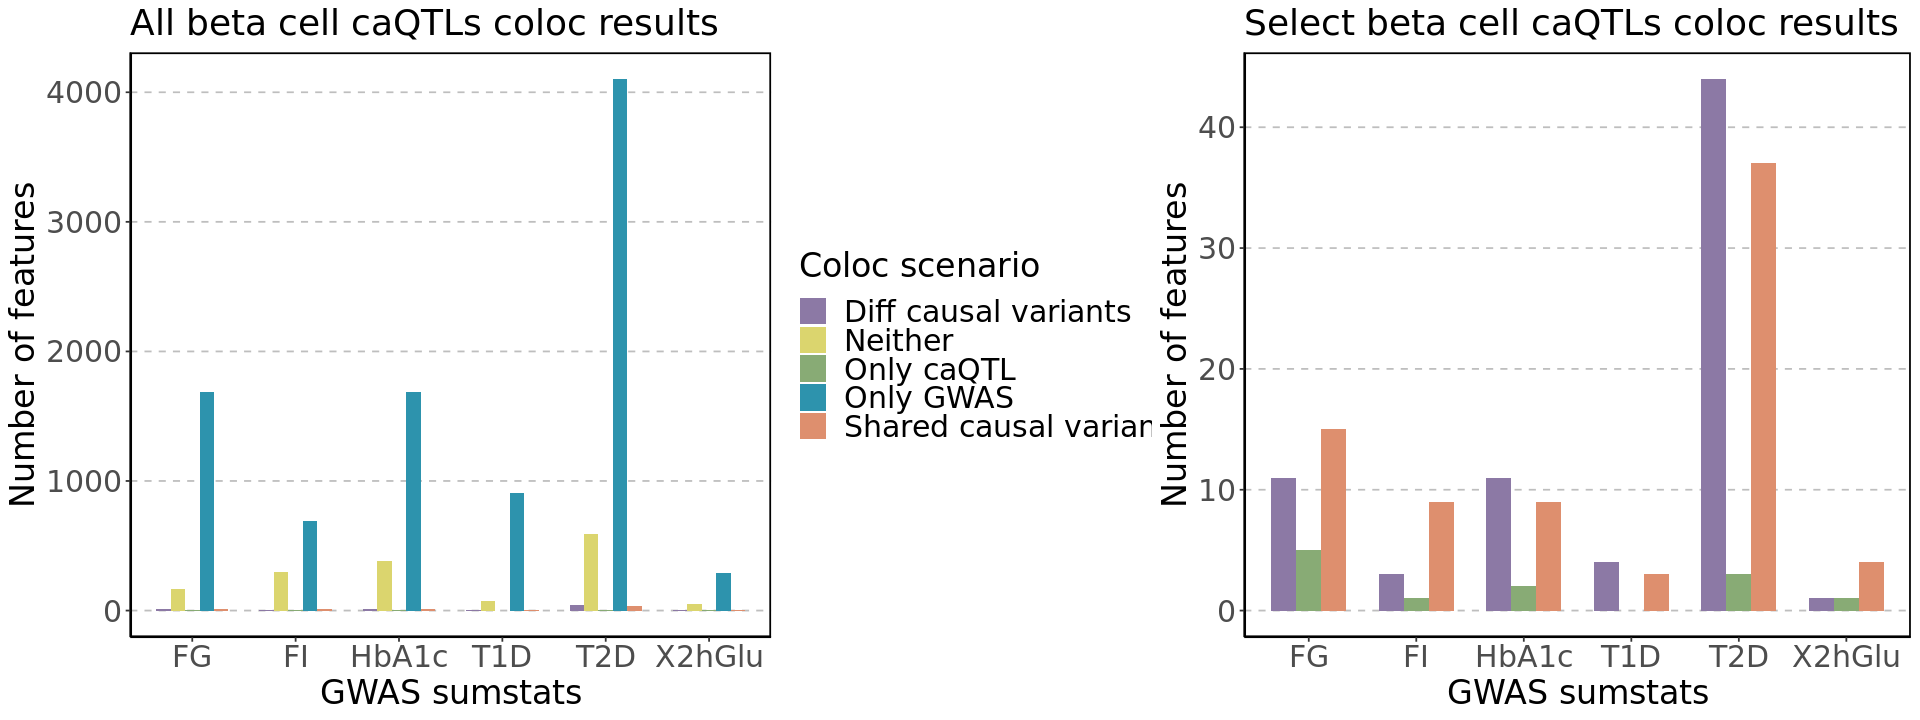

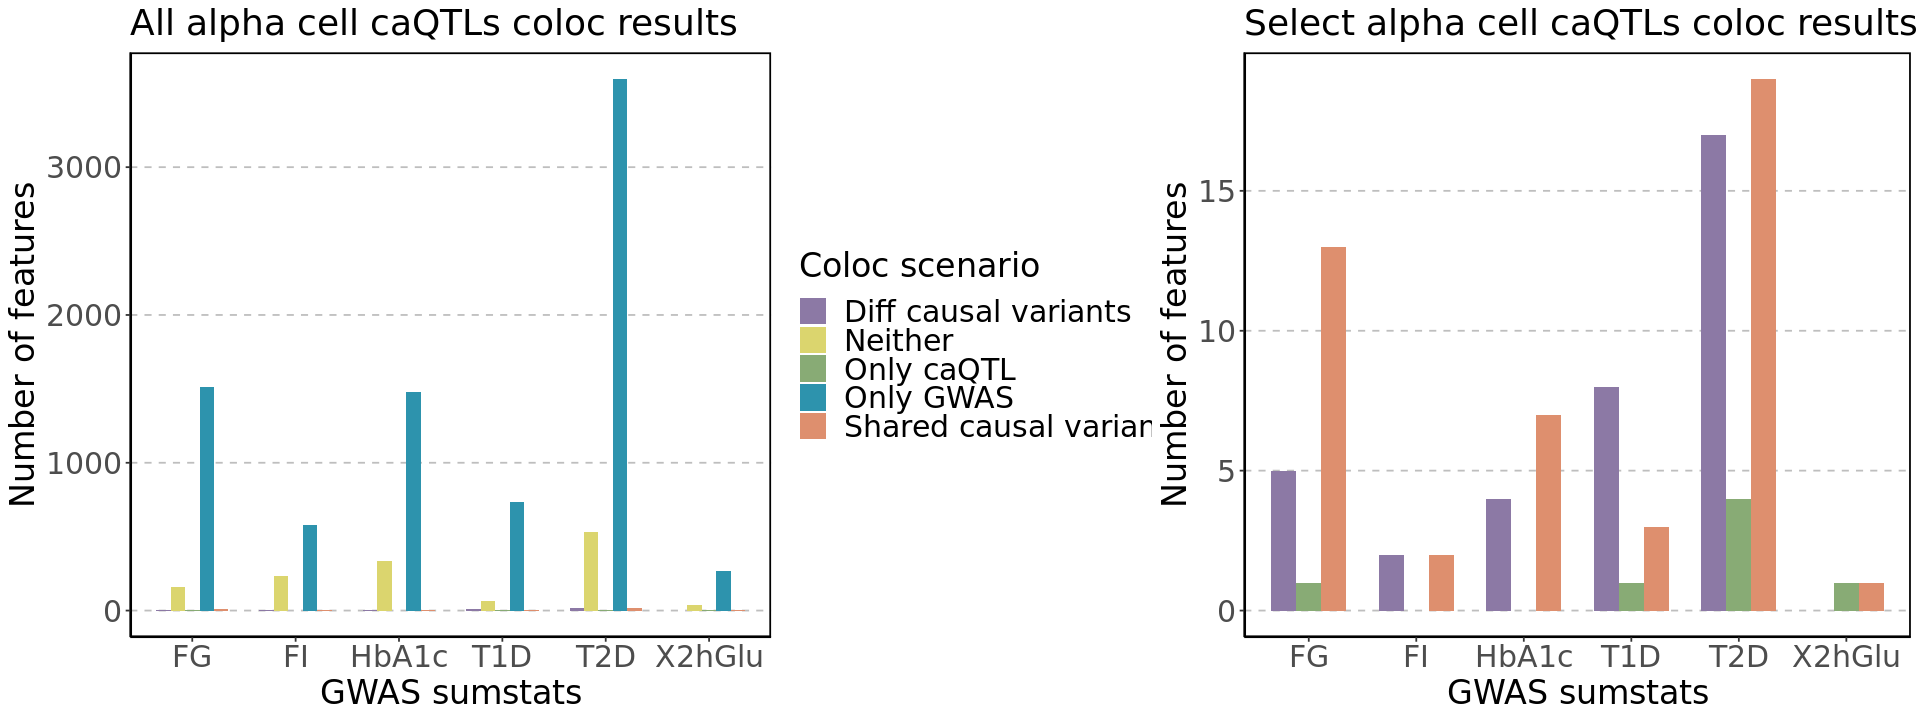

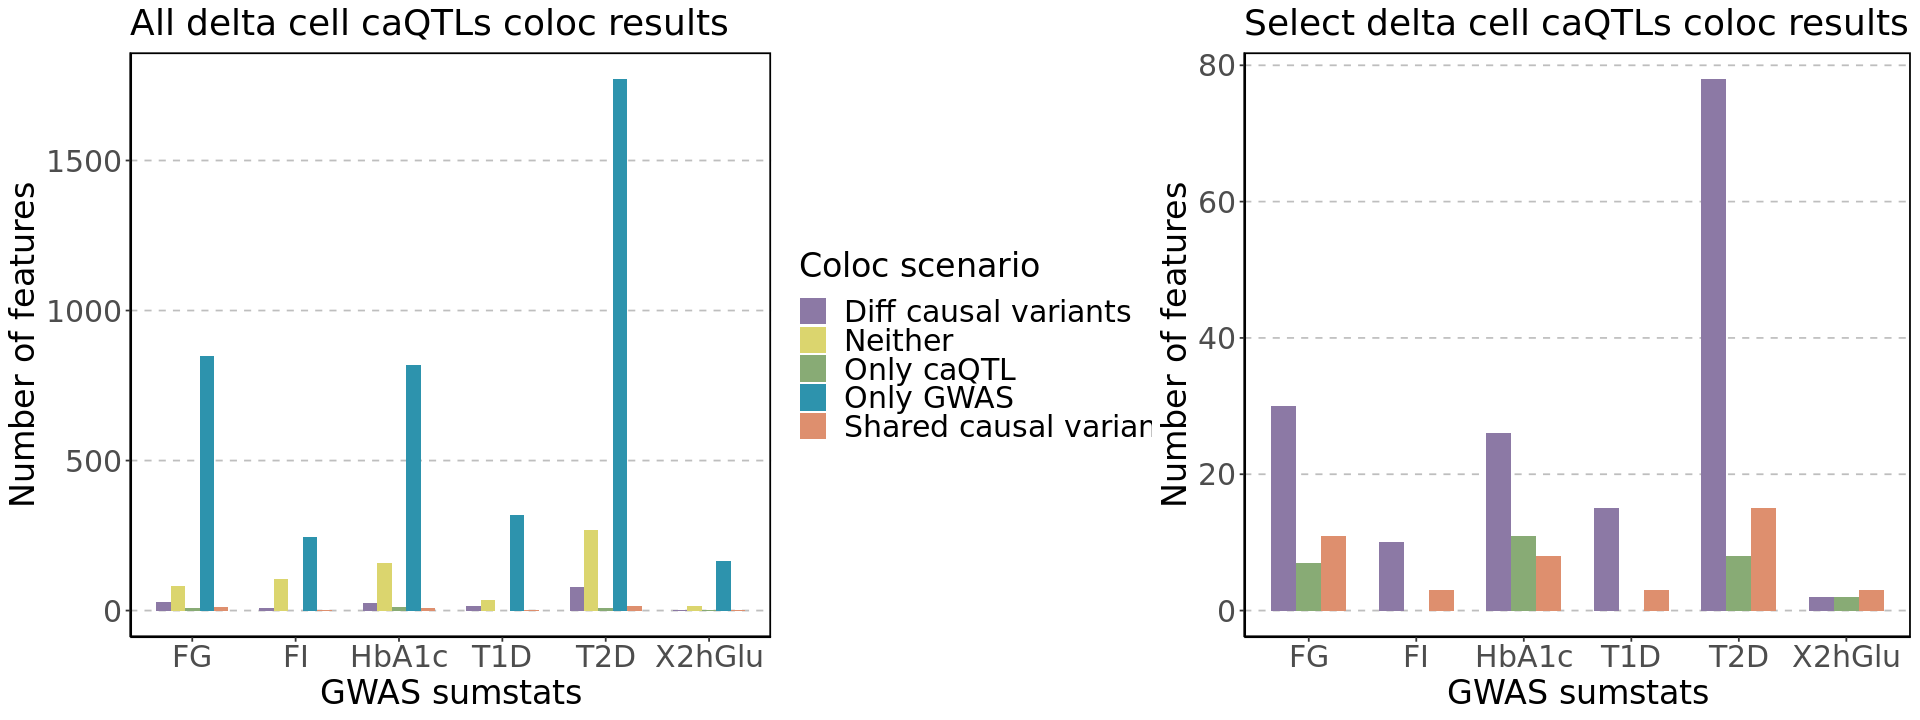

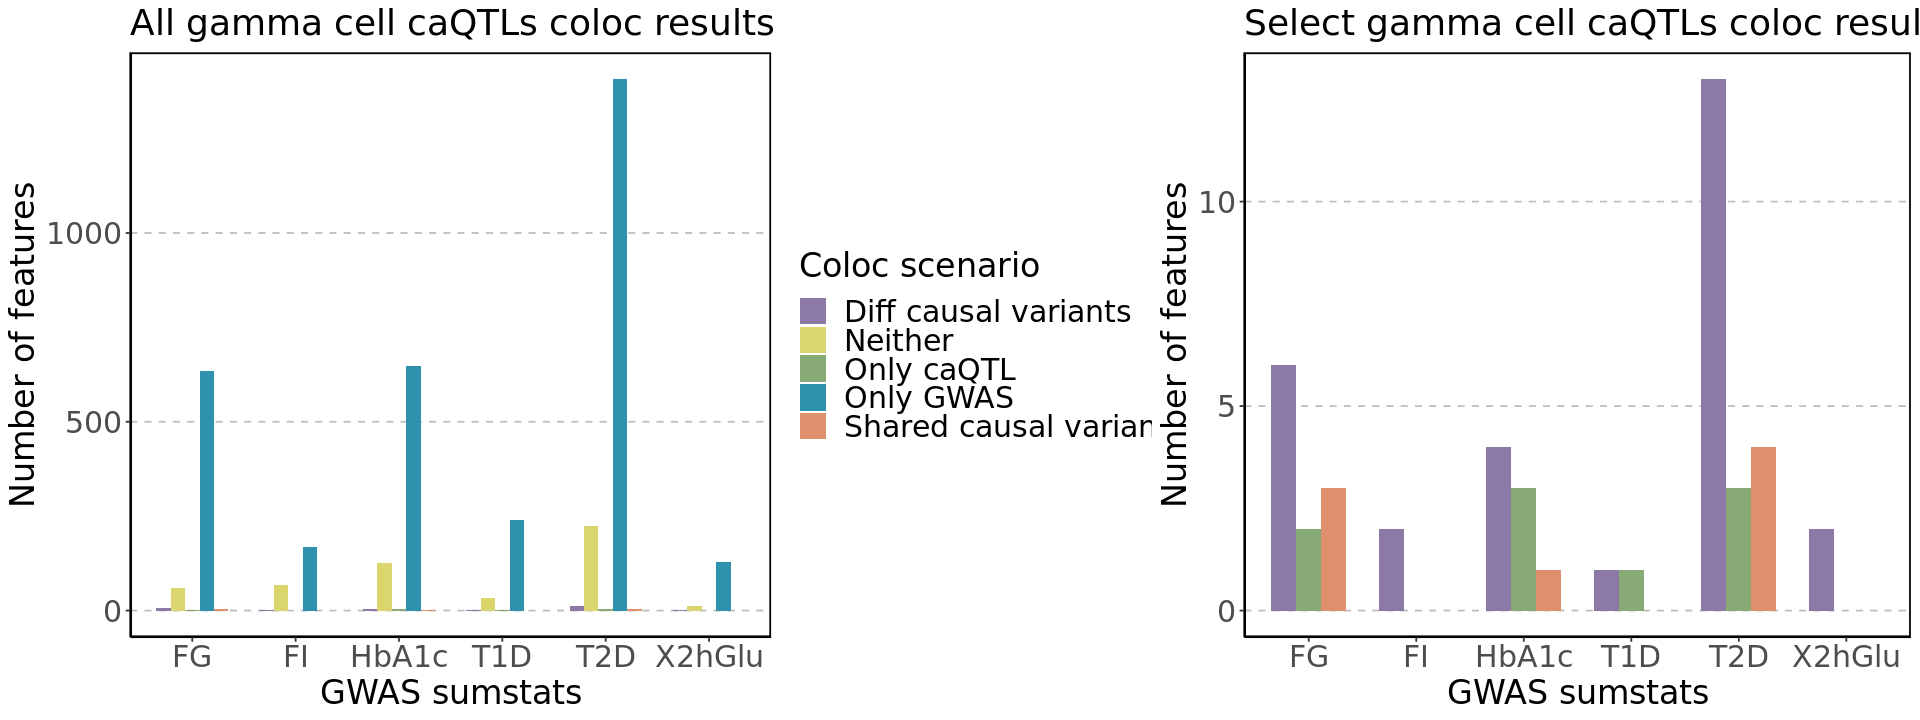

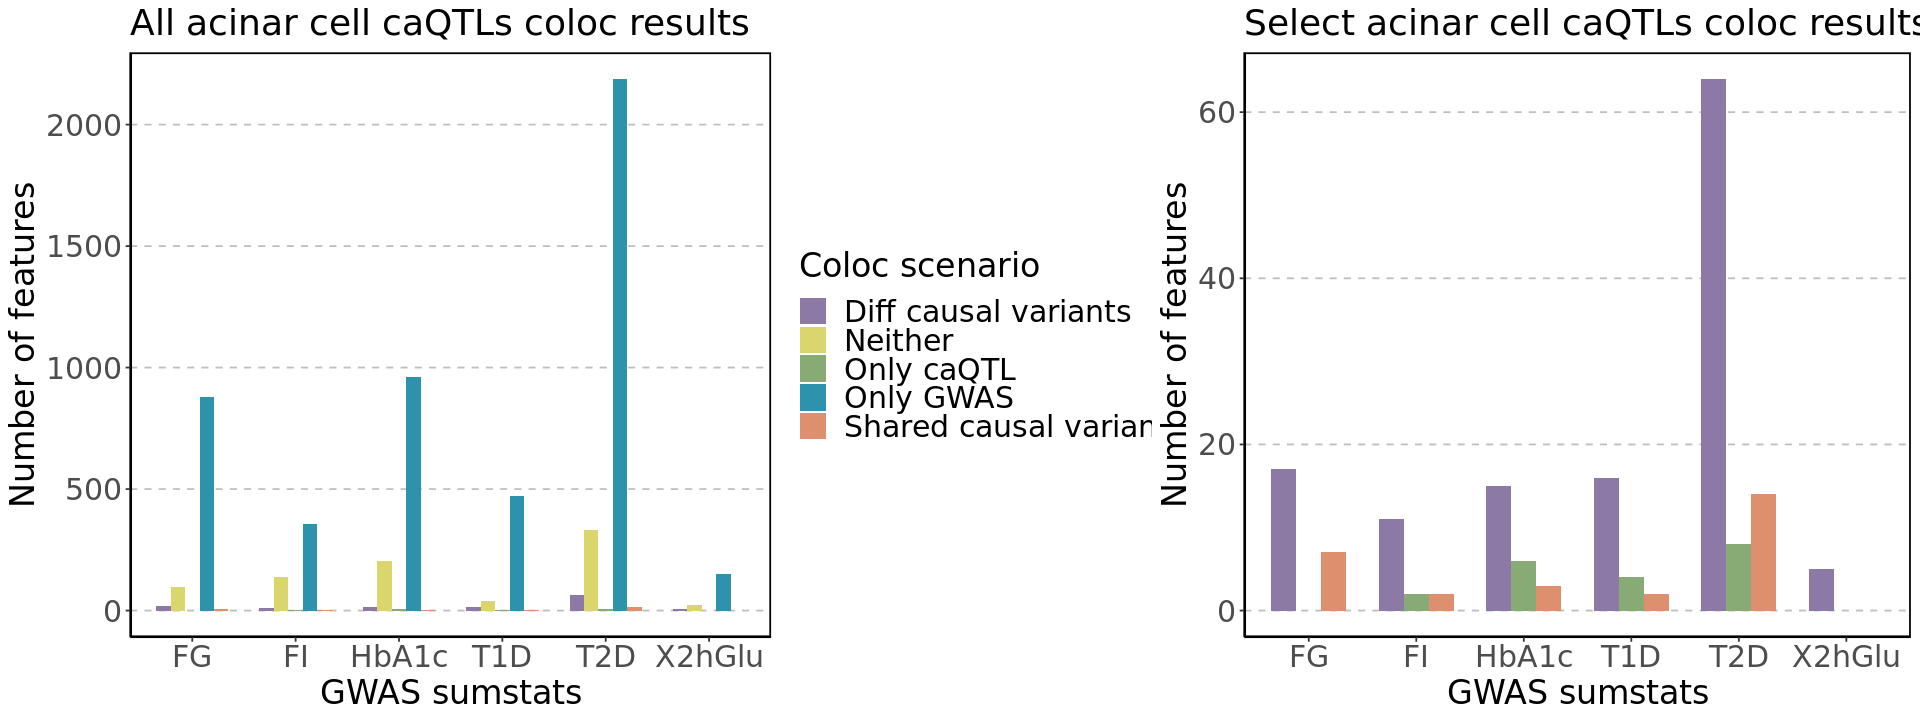

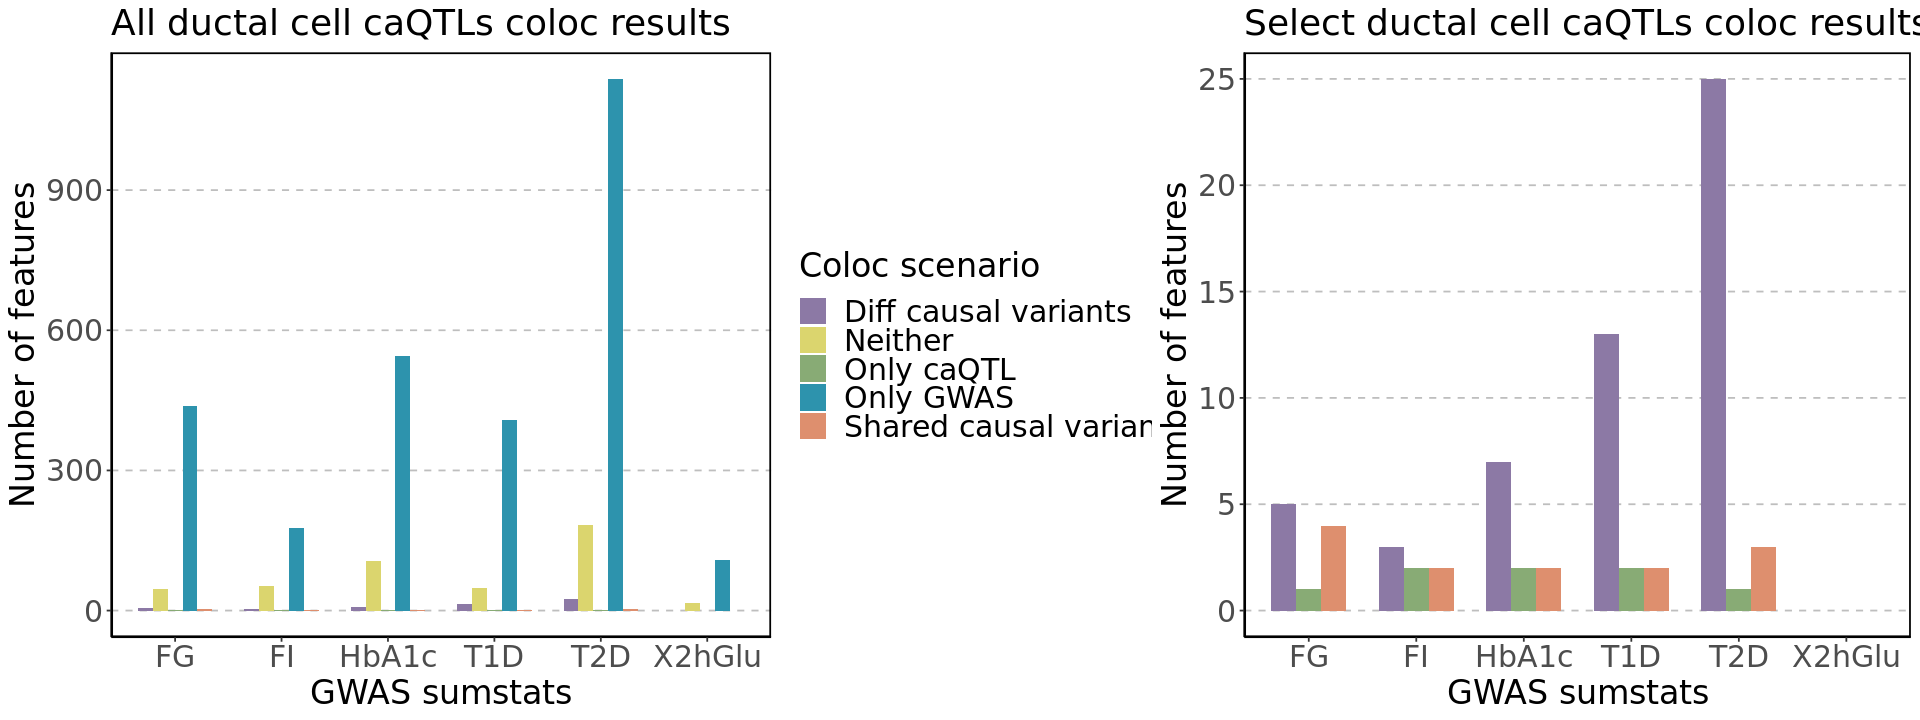

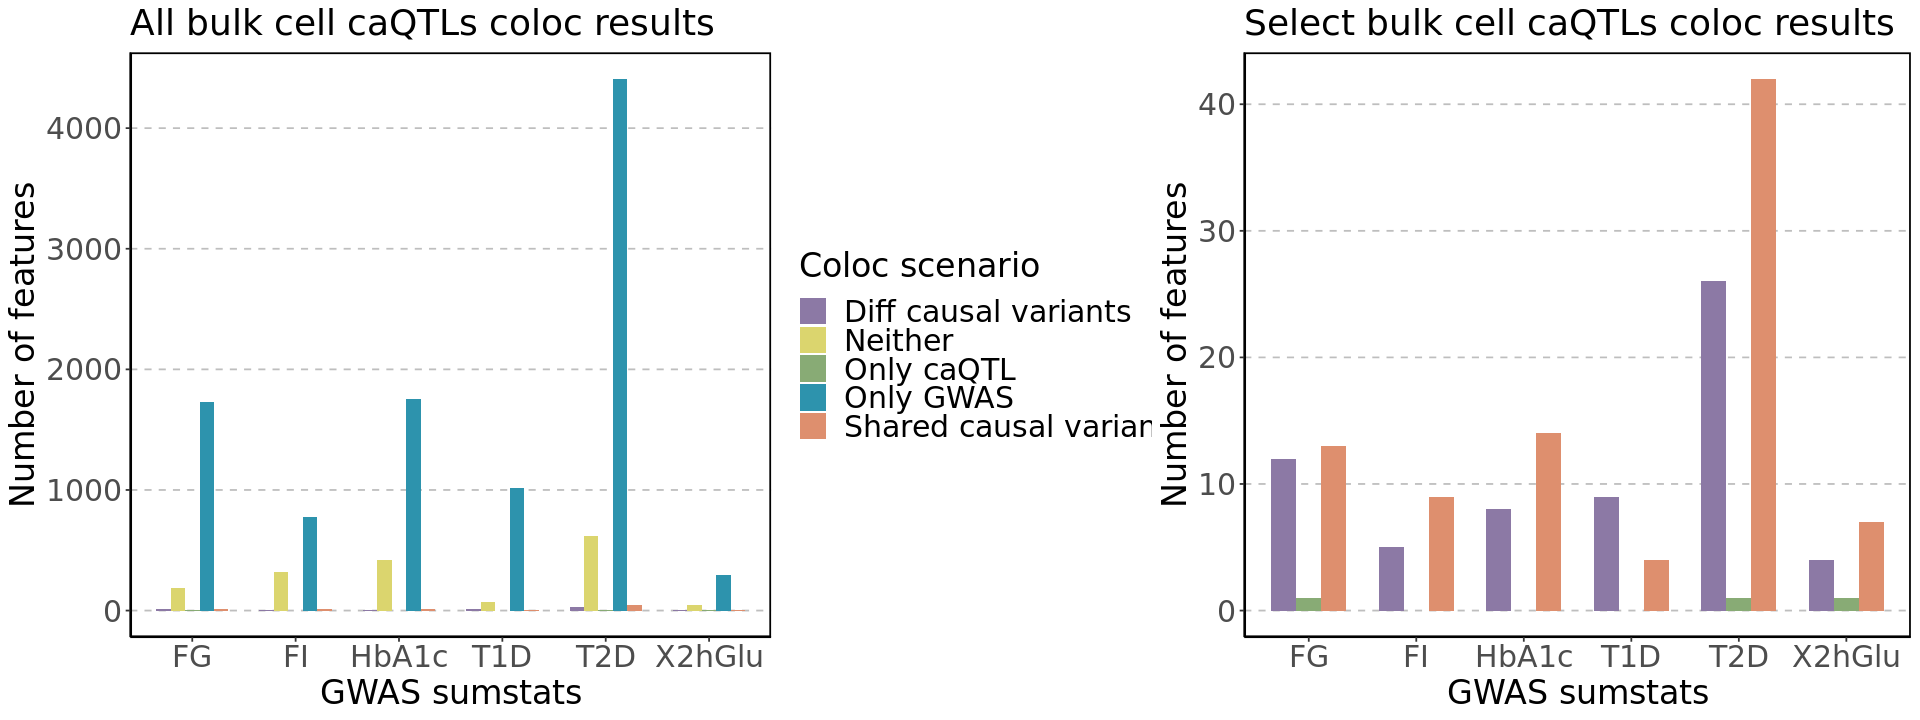

In [27]:
for(celltype in celltypes){
    summarize_ct_results(celltype, gwas_prefixes)
}

## Summarize all ppH4 results into one dataframe

In [10]:
gwas_prefixes <- c('T1D','T2D','2hGlu','FG','FI','HbA1c')
celltypes <- c('beta','alpha','delta','gamma','acinar','ductal','bulk')

In [11]:
outdir

[1] "/nfs/lab/projects/multiomic_islet/outputs/genotypes/240521_caQTL_GWAS_coloc_cts"

In [12]:
all_res <- data.frame()

for(gwas in gwas_prefixes){
    for(celltype in celltypes){
        res_fp <- file.path(outdir,gwas,sprintf('%s_caQTL_features_%s_coloc.MAX_PROB_ppH4.txt',celltype,gwas))
        res <- read.table(res_fp, sep='\t', header=TRUE)
        if(dim(res)[1] > 0){
            res$caQTL_celltype <- celltype
            res$GWAS <- gwas
            all_res <- rbind(all_res,res)            
        }
    }
}

#summarize all cell types per cRE in a few columns
all_res <- all_res %>% rename(cre=feature_name) %>%
            group_by(cre,GWAS) %>% 
            mutate(celltypes_per_GWAS=paste(caQTL_celltype,collapse=',')) %>%
            group_by(cre) %>%
            mutate(GWAS_per_cre=paste(unique(GWAS),collapse=','))
dim(all_res)

[1] 303   7

In [109]:
#write to a file
out_fp <- file.path(outdir,'ppH4_results','all_ct_caQTL_features_all_GWAS_color.MAX_PROB_ppH4.txt')
write.table(all_res,out_fp,sep='\t',row.names=F,quote=F)

In [110]:
table(all_res$GWAS,all_res$caQTL_celltype)

       
        acinar alpha beta bulk delta ductal gamma
  2hGlu      0     1    4    7     3      0     0
  FG         7    13   15   13    11      4     3
  FI         2     2    9    9     3      2     0
  HbA1c      3     7    9   14     8      2     1
  T1D        2     3    3    4     3      2     0
  T2D       14    19   37   42    15      3     4

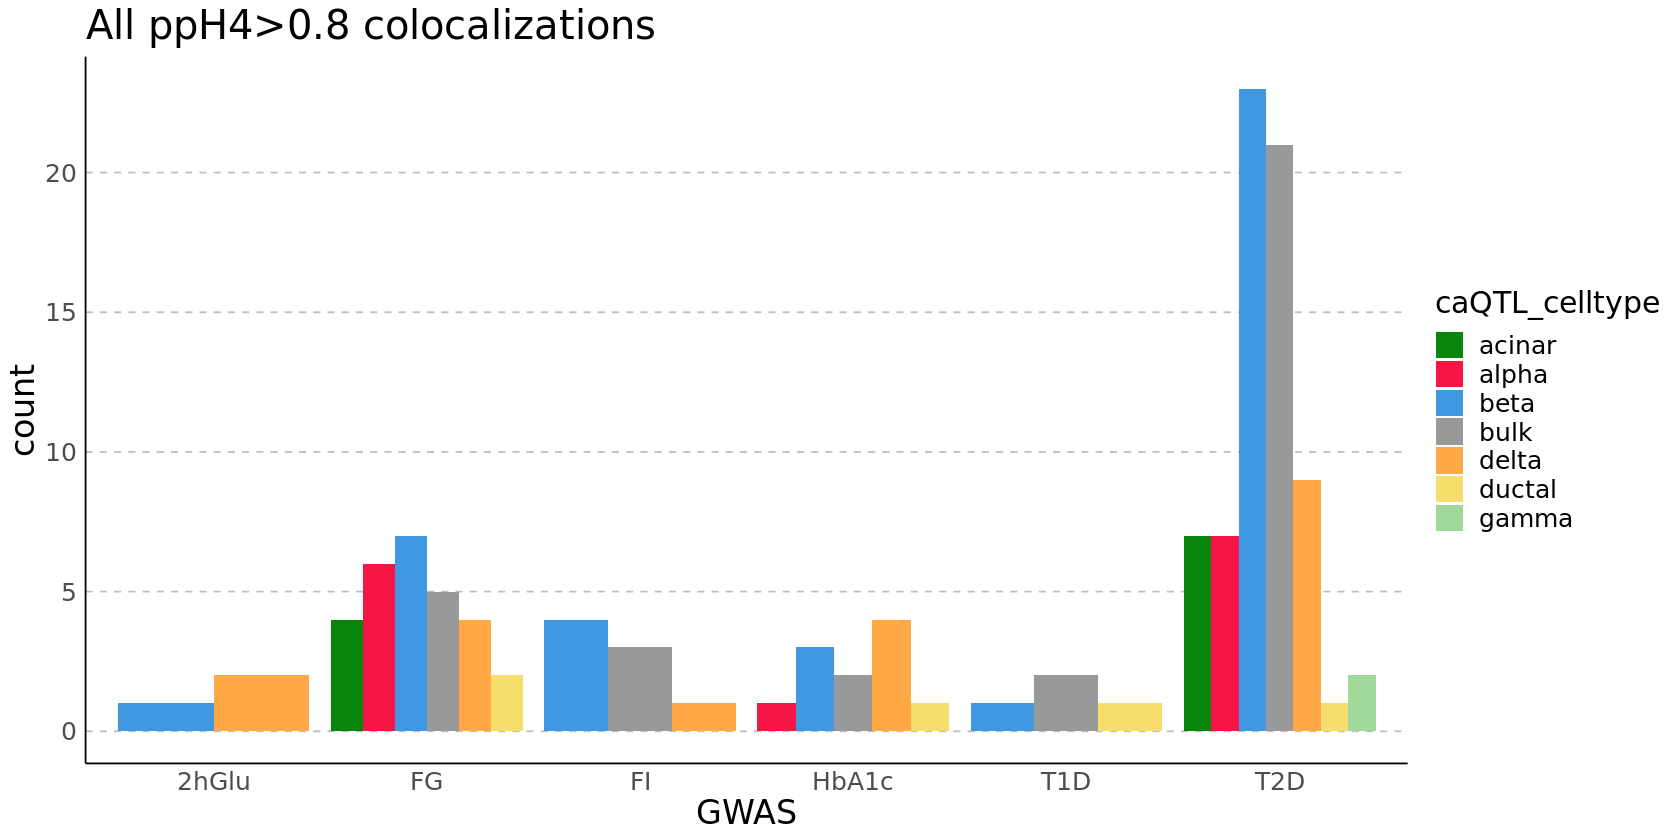

In [16]:
#make summary barplot of this!
options(repr.plot.width=14, repr.plot.height=7)
p1 <- ggplot(subset(all_res,prob>0.8), aes(x=GWAS, fill=caQTL_celltype)) +
        geom_bar(position='dodge') + 
        scale_fill_manual(values=major_colors) + 
        ggtitle('All ppH4>0.8 colocalizations') +
        theme(title=element_text(size=20),
              axis.title=element_text(size=20),
              axis.text=element_text(size=15),
              axis.ticks=element_blank(),
              legend.title=element_text(size=18),
              legend.text=element_text(size=15),
              panel.grid.major.y=element_line(color='grey', size=0.5, linetype=2))
# p1$data$ct <- factor(x = p1$data$ct, levels = rev(ordered_celltypes))
# p1$data$library <- factor(x=p1$data$library, levels=beta_order)
#p1 <- 
p1